In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import cv2
import keras


In [8]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset4/"
# if os.path.exists(wdr):
#     remove_tree(wdr)
# os.mkdir(wdr)
# copy_tree(train,wdr)
# copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['BT_CNN_model10', 'BT_CNN_model11', 'BT_CNN_model12', 'BT_CNN_model13', 'glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
work='./dataset4/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=200
ida=[200,200]
DIM=(idm,idm)

In [10]:
train_data_gen = IDG(rescale=1./255)
# train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=6500)
train_data_gen = train_data_gen.flow_from_directory(directory=work, target_size=DIM, batch_size=10183) #12 for more good res

Found 10183 images belonging to 6 classes.


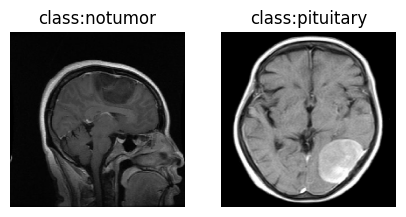

In [11]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(5,5))
    for i in range(2):
        ax=plt.subplot(2,2,i+1)
        idx=randint(0,200)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))

show_images(train_data_gen)

In [12]:
train_data,train_labels=train_data_gen.next()

In [13]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10632, 200, 200, 3) (10632, 4)


In [14]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [15]:
base_model = EfficientNetB7(input_shape=(200, 200, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 200, 200, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 200, 200, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 200, 200, 3)          0         ['normalization[0

In [16]:
custommodel=tf.keras.Sequential([base_model,Dropout(0.10),
                            GlobalAveragePooling2D(),Flatten(),
                            BatchNormalization(),
                            Dense(512,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(256,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(128,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(64,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(4,activation='softmax'),
                            ],name="inception_cnn_model")

In [17]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
custommodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
custommodel.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 2560)        0         
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                               

In [18]:
EPOCHS = 10
history = custommodel.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/10
213/213 [==============================] - 1161s 5s/step - loss: 1.4168 - train_acc: 0.3464 - val_acc: 0.6181 - f1_score: 0.3484 - val_loss: 1.3318 - val_train_acc: 0.3275 - val_val_acc: 0.6284 - val_f1_score: 0.2296
Epoch 2/10
213/213 [==============================] - 950s 4s/step - loss: 1.3112 - train_acc: 0.3642 - val_acc: 0.6463 - f1_score: 0.3672 - val_loss: 1.2133 - val_train_acc: 0.3862 - val_val_acc: 0.6901 - val_f1_score: 0.2834
Epoch 3/10
213/213 [==============================] - 726s 3s/step - loss: 1.2798 - train_acc: 0.3787 - val_acc: 0.6648 - f1_score: 0.3819 - val_loss: 1.1888 - val_train_acc: 0.4562 - val_val_acc: 0.7277 - val_f1_score: 0.4252
Epoch 4/10
213/213 [==============================] - 813s 4s/step - loss: 1.2633 - train_acc: 0.3861 - val_acc: 0.6701 - f1_score: 0.3863 - val_loss: 1.1796 - val_train_acc: 0.4480 - val_val_acc: 0.7318 - val_f1_score: 0.4208
Epoch 5/10
213/213 [==============================] - 1436s 7s/step - loss: 1.2574 - train_

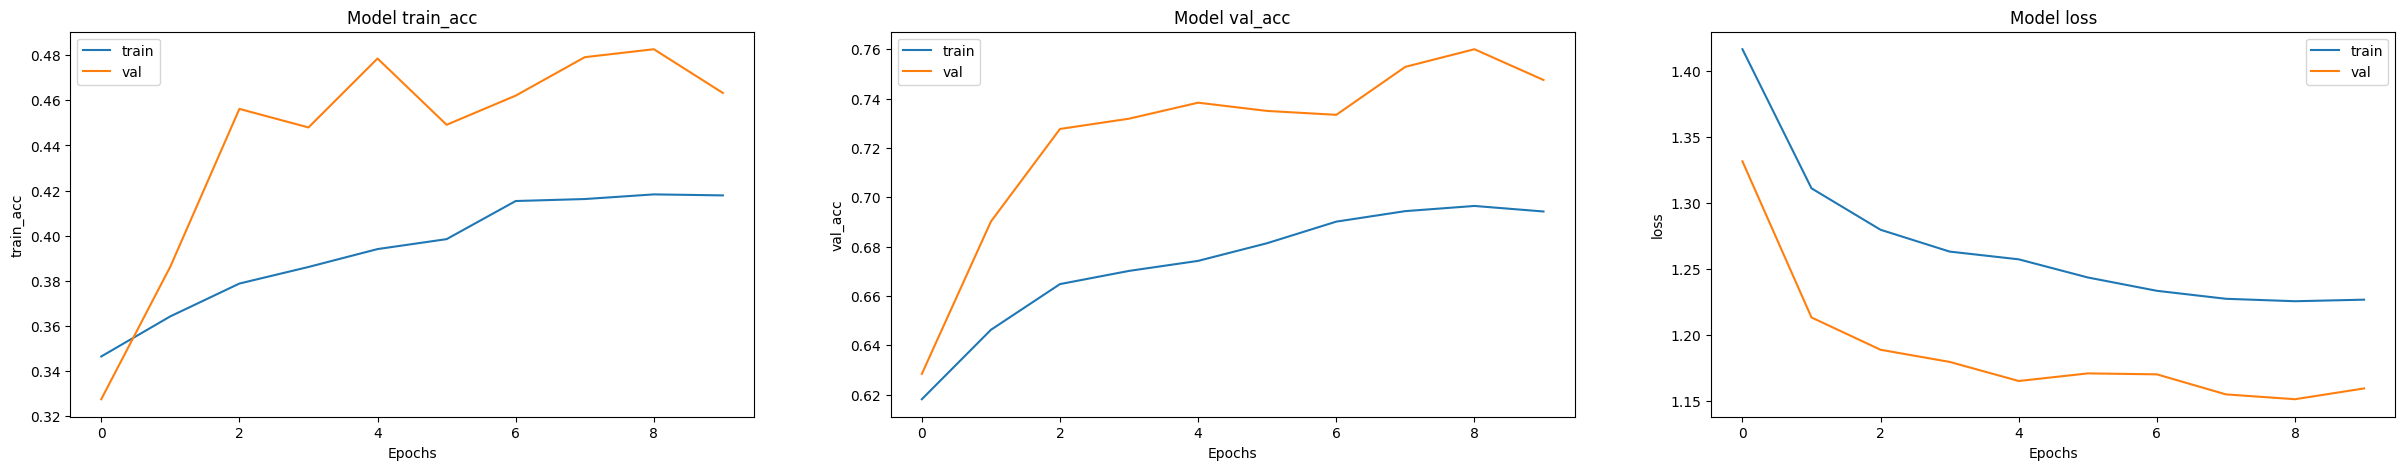

In [19]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [20]:
test_scores=custommodel.evaluate(test_data,test_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

67/67 [==============================] - 201s 3s/step - loss: 1.1871 - train_acc: 0.4480 - val_acc: 0.7307 - f1_score: 0.4312
Loss:  1.1871365308761597
Accuracy:  0.4480488896369934


In [21]:
pred_labels=custommodel.predict(test_data)

67/67 [==============================] - 204s 3s/step


In [22]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(test_labels,pred_labels,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.36      0.83      0.50       506
  meningioma       0.38      0.28      0.32       560
     notumor       0.81      0.51      0.62       541
   pituitary       0.50      0.19      0.28       520

   micro avg       0.45      0.45      0.45      2127
   macro avg       0.51      0.45      0.43      2127
weighted avg       0.51      0.45      0.43      2127
 samples avg       0.45      0.45      0.45      2127



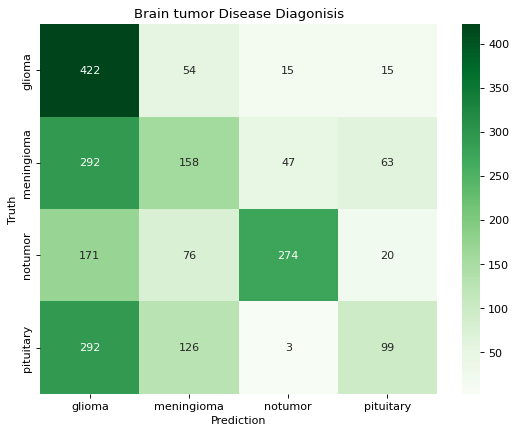

In [23]:
pred_ls=np.argmax(pred_labels,axis=1)
test_ls=np.argmax(test_labels,axis=1)
conf_arr=confusion_matrix(test_ls,pred_ls)
plt.figure(figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
ax=sns.heatmap(conf_arr,cmap='Greens',annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
plt.title('Brain tumor Disease Diagonisis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [24]:
print('Balanced Accuracy score {}%'.format(round(BAS(test_ls,pred_ls)*100,2)))
print('Matthews Correleation Corrcoef {}%'.format(round(MCC(test_ls,pred_ls)*100,2)))

Balanced Accuracy score 45.32%
Matthews Correleation Corrcoef 29.58%


In [25]:
custom_incmodel_dir=wdr+"BT_CNN_model11"
custommodel.save(custom_incmodel_dir,save_format='h5')
os.listdir(wdr)

c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['BT_CNN_model10',
 'BT_CNN_model11',
 'BT_CNN_model12',
 'BT_CNN_model13',
 'glioma',
 'meningioma',
 'notumor',
 'pituitary']

In [26]:
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./testim2.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (200, 200))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./dataset4/BT_CNN_model11')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class is:', ci[pci])


1/1 [==============================] - 3s 3s/step
[0.327795   0.27495027 0.13480304 0.26245168]
The predicted class is: glioma


In [27]:
# import cv2
# import numpy as np

# # Load the image using cv2
# image = cv2.imread('Te-pi_0116.jpg')

# # Convert the image to a matrix array
# image_array = np.array(image)

# # Save the array to a file
# np.save('image_array.npy', image_array)


In [28]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the array from the .npy file
# image_array = np.load('image_array.npy')

# # Reconstruct the image using cv2
# reconstructed_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

# # Display the reconstructed image
# plt.imshow(reconstructed_image)
# plt.axis('off')
# plt.show()

# # Alternatively, save the reconstructed image
# cv2.imwrite('reconstructed_image.jpg', reconstructed_image);
